In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [2]:
!pip install lightgbm

In [3]:
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import KMeansSMOTE
#from collections import Counter
#from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
#from imblearn.over_sampling import SMOTE
from sklearn import metrics
#from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
# xgboost для классификации
#from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from joblib import dump

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [4]:
ecg_df_HTV = pd.read_csv("/kaggle/input/electrocardiogram-database-for-arrhythmia-study/ecg_df_rhythm.csv", index_col=0)

In [5]:
ecg_df_HTV[:3]

,0_Mean RR (ms),0_STD RR/SDNN (ms),0_Mean HR (Kubios' style) (beats/min),0_Mean HR (beats/min),0_STD HR (beats/min),0_Min HR (beats/min),0_Max HR (beats/min),0_RMSSD (ms),0_NNxx,0_pNNxx (%),...,11_Min_P,11_Max_Q,11_Min_Q,11_Max_S,11_Min_S,11_Max_T,11_Min_T,age,sex,rhythm
0,-0.153063,-0.561229,-0.083994,-0.126195,-0.530526,0.203470,-0.348168,-0.520452,-0.728876,-0.859674,...,0.044933,-0.359817,-0.148760,-0.292535,-0.000366,0.039331,-0.326886,0.136332,-0.666883,SR
1,0.388922,-0.576440,-0.515920,-0.547819,-0.558183,-0.254884,-0.669709,-0.528545,-1.014266,-1.156689,...,0.390574,-0.464482,0.239995,-0.374881,0.347704,-0.253178,-0.231698,0.136332,-0.666883,SR
2,0.491271,-0.590281,-0.586560,-0.616799,-0.568887,-0.331226,-0.720878,-0.507999,-0.728876,-0.785421,...,0.044933,-0.255152,0.239995,-0.292535,-0.000366,-0.019170,0.244242,0.136332,-0.666883,SR


In [6]:
#ecg_df_HTV.to_csv("ecg_df_HTV_PTB_XL_arrytmia.csv")

In [7]:
def Entering_missing_values(df,name):
    df_numeric = ecg_df_HTV.select_dtypes(include=[np.number])
    numeric_cols = df_numeric.columns.values
    for i in df[name].value_counts().index:
        df_1 = df[df[name] == i]
        for col in numeric_cols:
            if (np.mean(df_1[col].isnull()) > 0) and (np.mean(df_1[col].isnull()) < 1):
                df_1[col] = df_1[col].fillna(df_1[col].median())                        
        df[df[name] == i] = df_1
    return df

In [8]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
ecg_df_HTV_sns= ecg_df_HTV.copy()
ecg_df_HTV_sns=Entering_missing_values(ecg_df_HTV_sns,"rhythm")

In [9]:
ecg_df_HTV_sns.index = pd.RangeIndex(start=0, stop=len(ecg_df_HTV) )

In [10]:
for col in ecg_df_HTV.columns:
    pct_missing = np.sum(ecg_df_HTV[col].isnull())
    if round(pct_missing*100) >0:
        print('{} - {}%'.format(col, round(pct_missing*100)))

In [11]:
ecg_df_HTV_sns= ecg_df_HTV_sns.dropna()
ecg_df_HTV_sns["rhythm"],uniques_rhythm = pd.factorize(ecg_df_HTV_sns.rhythm)


In [12]:
ecg_df_HTV["rhythm"].value_counts()[:6]

rhythm
SR       26890
SBRAD     5419
AFIB      4418
STACH     3577
SARRH     1136
AFLT       692
Name: count, dtype: int64

In [13]:
ecg_df_HTV_sns["rhythm"].value_counts()[:6]

rhythm
0    26890
4     5419
1     4418
2     3577
3     1136
5      692
Name: count, dtype: int64

In [14]:
ecg_df_HTV_sns = ecg_df_HTV_sns[ecg_df_HTV_sns["rhythm"] != 6]

In [15]:
ecg_df_HTV_sns_rutm = ecg_df_HTV_sns.copy().dropna()

In [16]:
df_new = ecg_df_HTV_sns_rutm.copy()
#df_new = df_new[df_new['rhythm'] < 5 ]
df_new.rhythm.value_counts()
n = 1000
df_new =ecg_df_HTV_sns_rutm[ecg_df_HTV_sns_rutm.rhythm == 0.0][:n ].copy()
for i in [1.0,2.0,3.0,4.0,5.0,6.0]:
    df_new = pd.concat([df_new, ecg_df_HTV_sns_rutm[ecg_df_HTV_sns_rutm.rhythm == i][:n ]], ignore_index=True)

In [17]:
df_new.rhythm.value_counts()

rhythm
0    1000
1    1000
2    1000
3    1000
4    1000
5     692
Name: count, dtype: int64

In [ ]:
import matplotlib.pyplot as plt
# Круговая диаграмма, секторы которой будут упорядочены и расположены против часовой стрелки:
labels = df_new.rhythm.value_counts()[:6].index
sizes = list(df_new.rhythm.value_counts()[:6])
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')#autopct='%1.1f%%'
plt.show()

In [18]:
df_corr_rhythm =df_new.corr(method='spearman')[["rhythm"]] #,"diagnostic"

In [19]:
def func_corr_a(name,df_corr_diagnostic,N):
    param = df_corr_diagnostic[((df_corr_diagnostic[name] > N)|(df_corr_diagnostic[name] < -N))&(df_corr_diagnostic[name] != 1)  ]
    list_corr_=[]
    for i in list(param.index):
        if '_' in i :
            if (i[i.index('_')+1:] in list_corr_) != True:
                list_corr_.append(i)
                list_corr_.append(i[i.index('_')+1:])
                list_corr_.append(param[name][i])
            else :
                if abs(list_corr_[list_corr_.index(i[i.index('_')+1:])+1]) < abs(param[name][i] ):
                    list_corr_[list_corr_.index(i[i.index('_')+1:])-1] = i   
                    list_corr_[list_corr_.index(i[i.index('_')+1:])+1] = param[name][i]
        else : 
            list_corr_.append(i)
            list_corr_.append(i)
            list_corr_.append(param[name][i])
    return list_corr_

In [20]:
list_corr_rhythm=func_corr_a("rhythm",df_corr_rhythm,0.005)
list_corr_rhythm[::3]

['3_Mean RR (ms)',
 '3_STD RR/SDNN (ms)',
 "3_Mean HR (Kubios' style) (beats/min)",
 '3_Mean HR (beats/min)',
 '3_STD HR (beats/min)',
 '3_Min HR (beats/min)',
 '3_Max HR (beats/min)',
 '3_RMSSD (ms)',
 '0_NNxx',
 '0_pNNxx (%)',
 '11_VLF_Peak (Hz)',
 '11_LF_Peak (Hz)',
 '6_HV_Peak (Hz)',
 '3_VLF_Abs (ms2)',
 '3_LF_Abs (ms2)',
 '3_HV_Abs (ms2)',
 '4_VLF_Rel (%)',
 '6_LF_Rel (%)',
 '6_HV_Rel (%)',
 '3_VLF_Log (-)',
 '3_LF_Log (-)',
 '3_HV_Log (-)',
 '6_LF_Norm (-)',
 '6_HV_Norm (-)',
 '6_LF/HF (-)',
 '3_Total Power (ms)',
 '6_Min_R',
 '3_Max_RR',
 '3_Min_RR',
 '9_Max_P',
 '10_Min_P',
 '6_Max_Q',
 '6_Min_Q',
 '0_Max_S',
 '7_Min_S',
 '6_Max_T',
 '7_Min_T',
 '6_Max_R',
 'age',
 'sex']

In [21]:
len(list_corr_rhythm[::3])

40

In [22]:
wew_twe = list_corr_rhythm[::3].copy()[:-2]
wew = []
A = " отведение "
for i in range(len(wew_twe)):
    wew.append([int(wew_twe[i].split("_")[0])+1,list_corr_rhythm[1::3][i]])
wew.sort()
for i in pd.DataFrame(wew).index:
    print(pd.DataFrame(wew)[0][i],A,pd.DataFrame(wew)[1][i])

1  отведение  Max_S
1  отведение  NNxx
1  отведение  pNNxx (%)
4  отведение  HV_Abs (ms2)
4  отведение  HV_Log (-)
4  отведение  LF_Abs (ms2)
4  отведение  LF_Log (-)
4  отведение  Max HR (beats/min)
4  отведение  Max_RR
4  отведение  Mean HR (Kubios' style) (beats/min)
4  отведение  Mean HR (beats/min)
4  отведение  Mean RR (ms)
4  отведение  Min HR (beats/min)
4  отведение  Min_RR
4  отведение  RMSSD (ms)
4  отведение  STD HR (beats/min)
4  отведение  STD RR/SDNN (ms)
4  отведение  Total Power (ms)
4  отведение  VLF_Abs (ms2)
4  отведение  VLF_Log (-)
5  отведение  VLF_Rel (%)
7  отведение  HV_Norm (-)
7  отведение  HV_Peak (Hz)
7  отведение  HV_Rel (%)
7  отведение  LF/HF (-)
7  отведение  LF_Norm (-)
7  отведение  LF_Rel (%)
7  отведение  Max_Q
7  отведение  Max_R
7  отведение  Max_T
7  отведение  Min_Q
7  отведение  Min_R
8  отведение  Min_S
8  отведение  Min_T
10  отведение  Max_P
11  отведение  Min_P
12  отведение  LF_Peak (Hz)
12  отведение  VLF_Peak (Hz)


male 0, female 1

In [23]:
def stardant(X_columns):
    #определяем смещение Центрируем данные относительно 0
    fix_displacement_min = X_columns.describe()
    for i in X_columns.describe().columns:   
        X_columns[i] = X_columns[i] - fix_displacement_min[i]["min"]
    fix_displacement = X_columns.describe()
    #Стандартизация по z-оценке
    for i in X_columns.describe().columns:   
        X_columns[i] = (X_columns[i] - fix_displacement[i]["mean"])/(fix_displacement[i]["std"])
    return X_columns ,fix_displacement_min,fix_displacement#

In [24]:
def stardant_N(X_columns,fix_displacement_min, fix_displacement):
    for i in X_rhythm.describe().columns:   
        X_columns[i] = X_columns[i] - fix_displacement_min[i]["min"]
    for i in X_rhythm.describe().columns:   
        X_columns[i] = (X_columns[i] - fix_displacement[i]["mean"])/(fix_displacement[i]["std"])
    return X_columns 

In [25]:
#ecg_df_HTV_new[list_corr_rhythm[::3]],fix_displacement_min,fix_displacement = stardant(ecg_df_HTV_new[list_corr_rhythm[::3]])

In [26]:
ecg_df_HTV_sns_rutm[list_corr_rhythm[::3]].describe()

,3_Mean RR (ms),3_STD RR/SDNN (ms),3_Mean HR (Kubios' style) (beats/min),3_Mean HR (beats/min),3_STD HR (beats/min),3_Min HR (beats/min),3_Max HR (beats/min),3_RMSSD (ms),0_NNxx,0_pNNxx (%),...,10_Min_P,6_Max_Q,6_Min_Q,0_Max_S,7_Min_S,6_Max_T,7_Min_T,6_Max_R,age,sex
count,42132.000000,42132.000000,42132.000000,42132.000000,42132.000000,42132.000000,42132.000000,42132.000000,42132.000000,42132.000000,...,42132.000000,42132.000000,42132.000000,42132.000000,42132.000000,42132.000000,42132.000000,42132.000000,42132.000000,42132.000000
mean,-0.020302,-0.042430,0.008528,0.000551,-0.035347,0.019130,-0.013923,-0.042190,0.007974,0.012103,...,-0.029356,0.011134,0.023214,0.011370,0.037652,-0.027378,-0.019932,-0.008381,-0.041006,0.047372
std,0.964938,0.919520,0.977207,0.981587,0.957849,0.966789,0.985903,0.915990,0.994918,0.993864,...,1.026030,0.982898,0.953911,0.953143,0.936197,0.945356,0.952556,0.967177,0.976884,1.018431
min,-2.383995,-0.553509,-2.647734,-2.634387,-0.776222,-2.760525,-2.140745,-0.507207,-1.299656,-1.527958,...,-100.191778,-11.110437,-58.206181,-40.360154,-23.679897,-4.962054,-21.350496,-3.319575,-2.654243,-0.666883
25%,-0.668534,-0.476723,-0.699024,-0.720938,-0.652620,-0.559408,-0.722517,-0.454350,-0.728876,-0.859674,...,-0.228604,-0.161112,0.001823,-0.266851,-0.425260,-0.422158,-0.630985,-0.469605,-0.343298,-0.666883
50%,-0.097167,-0.351872,-0.154019,-0.179198,-0.468345,-0.067732,-0.267734,-0.352356,-0.158097,0.142751,...,0.142225,0.049452,0.316525,0.188672,0.174004,-0.227055,-0.186742,-0.245936,0.005524,-0.666883
75%,0.545444,-0.101913,0.527531,0.520301,0.175671,0.543626,0.452622,-0.078217,0.412683,0.858769,...,0.420347,0.270544,0.419042,0.445821,0.661520,0.140639,0.488508,0.129250,0.223537,1.499483
max,8.203870,13.884787,6.255063,6.958579,7.410823,5.232150,7.777899,18.721974,4.978920,1.668181,...,16.273293,54.364418,4.986993,14.537622,2.206344,71.803466,8.307192,48.100140,10.339370,1.499483


## rhythm

In [27]:
df_test = ecg_df_HTV_sns_rutm.copy()

In [28]:
df_new = ecg_df_HTV_sns_rutm.copy()
#df_new = df_new[df_new['rhythm'] < 5 ]
df_new.rhythm.value_counts()

rhythm
0    26890
4     5419
1     4418
2     3577
3     1136
5      692
Name: count, dtype: int64

In [29]:
df_test 

,0_Mean RR (ms),0_STD RR/SDNN (ms),0_Mean HR (Kubios' style) (beats/min),0_Mean HR (beats/min),0_STD HR (beats/min),0_Min HR (beats/min),0_Max HR (beats/min),0_RMSSD (ms),0_NNxx,0_pNNxx (%),...,11_Min_P,11_Max_Q,11_Min_Q,11_Max_S,11_Min_S,11_Max_T,11_Min_T,age,sex,rhythm
0,-0.153063,-0.561229,-0.083994,-0.126195,-0.530526,0.203470,-0.348168,-0.520452,-0.728876,-0.859674,...,0.044933,-0.359817,-0.148760,-0.292535,-0.000366,0.039331,-0.326886,0.136332,-0.666883,0
1,0.388922,-0.576440,-0.515920,-0.547819,-0.558183,-0.254884,-0.669709,-0.528545,-1.014266,-1.156689,...,0.390574,-0.464482,0.239995,-0.374881,0.347704,-0.253178,-0.231698,0.136332,-0.666883,0
2,0.491271,-0.590281,-0.586560,-0.616799,-0.568887,-0.331226,-0.720878,-0.507999,-0.728876,-0.785421,...,0.044933,-0.255152,0.239995,-0.292535,-0.000366,-0.019170,0.244242,0.136332,-0.666883,0
3,0.288899,-0.479533,-0.443854,-0.476953,-0.491699,-0.215435,-0.588493,-0.497463,-0.728876,-0.785421,...,0.505787,-0.255152,0.239995,-0.169016,0.376710,0.858357,1.862440,0.136332,-0.666883,0
4,-0.103865,-0.375733,-0.127784,-0.166998,-0.385191,0.059492,-0.313845,-0.507286,-1.014266,-1.193816,...,0.275360,0.111174,0.162244,-0.395468,-0.000366,-0.004545,0.339431,0.136332,-0.666883,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42127,-0.778497,1.715524,0.578779,0.776008,2.063037,-0.254884,1.248192,1.652342,1.554242,1.256557,...,0.367531,0.058842,0.041730,-1.161285,-0.728412,0.077358,-0.783789,0.441551,-0.666883,5
42128,-2.112482,-0.634842,3.247646,3.124736,-0.537036,3.727777,1.935656,-0.565939,-1.299656,-1.527958,...,0.505787,-0.354584,0.041730,-11.911554,-8.867451,-0.779694,-0.041322,-0.997339,-0.666883,5
42129,0.387759,-0.383234,-0.515100,-0.545722,-0.442950,-0.418592,-0.648592,-0.267154,-0.158097,-0.042883,...,-0.029956,-0.197587,0.593761,-0.938951,-0.119290,-0.650990,-0.041322,1.051989,-0.666883,5
42130,-2.310737,-0.582081,3.946892,3.808495,-0.338408,4.379785,2.512988,-0.527967,-0.728876,-1.237400,...,0.027651,-0.071989,0.232220,-0.720734,-0.940155,0.176811,-1.297804,0.049126,-0.666883,5


In [30]:
n = 3000
df_new =df_test[df_test.rhythm == 0.0][:n ].copy()
for i in [1.0,2.0,3.0,4.0,5.0,6.0]:
    df_new = pd.concat([df_new, df_test[df_test.rhythm == i][:n ]], ignore_index=True)

In [31]:
df_new.rhythm.value_counts()

rhythm
0    3000
1    3000
2    3000
4    3000
3    1136
5     692
Name: count, dtype: int64

In [32]:
list_corr_rhythm_2 = list_corr_rhythm[::3]
list_corr_rhythm_2.append('rhythm')

In [33]:
df_new.columns[:-1]

Index(['0_Mean RR (ms)', '0_STD RR/SDNN (ms)',
       '0_Mean HR (Kubios' style) (beats/min)', '0_Mean HR (beats/min)',
       '0_STD HR (beats/min)', '0_Min HR (beats/min)', '0_Max HR (beats/min)',
       '0_RMSSD (ms)', '0_NNxx', '0_pNNxx (%)',
       ...
       '11_Max_P', '11_Min_P', '11_Max_Q', '11_Min_Q', '11_Max_S', '11_Min_S',
       '11_Max_T', '11_Min_T', 'age', 'sex'],
      dtype='object', length=458)

In [34]:
# df_new = df_new[df_new.rhythm < 5]
#X_rhythm,  y_rhythm  = df_new[list_corr_rhythm_2[:-1]], df_new['rhythm']
df_new = df_new.dropna()
X_rhythm,  y_rhythm  = df_new[df_new.columns[:-1]], df_new['rhythm']
y_rhythm=y_rhythm.astype('int')

In [35]:
sm = KMeansSMOTE(random_state=42,cluster_balance_threshold = 0.01)
X_rhythm, y_rhythm = sm.fit_resample(X_rhythm, y_rhythm)
sm = BorderlineSMOTE(random_state=42)
X_rhythm, y_rhythm = sm.fit_resample(X_rhythm, y_rhythm)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [38]:
X_train, X_valid, y_train, y_valid = train_test_split(X_rhythm, y_rhythm, test_size=0.1, random_state=0)#test_size=0.3 # random_state=1235

## LGBMClassifier

In [49]:
from sklearn.metrics import f1_score,accuracy_score,balanced_accuracy_score

In [47]:
model_LGBMClassifier = LGBMClassifier()
model_LGBMClassifier.fit(X_train, y_train)
print("score ",model_LGBMClassifier.score(X_train, y_train))
y_predict = model_LGBMClassifier.predict(X_valid)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9999
[LightGBM] [Info] Number of data points in the train set: 145233, number of used features: 40
[LightGBM] [Info] Start training from score -1.792607
[LightGBM] [Info] Start training from score -1.786794
[LightGBM] [Info] Start training from score -1.794221
[LightGBM] [Info] Start training from score -1.792731
[LightGBM] [Info] Start training from score -1.792648
[LightGBM] [Info] Start training from score -1.791574
score  0.9750745354017337


In [50]:
print("f1_score micro ",f1_score(y_valid,y_predict, average='micro')) #"samples"
print("f1_score macro ",f1_score(y_valid,y_predict, average='macro'))
print("f1_score weighted ",f1_score(y_valid,y_predict, average='weighted'))

f1_score micro  0.9586044494019954
f1_score macro  0.9583388331994408
f1_score weighted  0.9584019961237733


In [51]:
accuracy_score(y_valid, y_predict),balanced_accuracy_score(y_valid, y_predict)

(0.9586044494019954, 0.9585971805455326)

In [52]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, y_predict))

              precision    recall  f1-score   support

           0       0.94      0.89      0.91      2710
           1       0.95      0.96      0.96      2569
           2       0.99      0.98      0.99      2749
           3       0.97      0.97      0.97      2713
           4       0.93      0.97      0.95      2711
           5       0.97      0.98      0.98      2685

    accuracy                           0.96     16137
   macro avg       0.96      0.96      0.96     16137
weighted avg       0.96      0.96      0.96     16137



In [55]:
print(classification_report(df_test['rhythm'], model_LGBMClassifier.predict(df_test[X_rhythm.columns])))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94     26890
           1       0.87      0.90      0.89      4418
           2       0.96      0.96      0.96      3577
           3       0.63      0.69      0.66      1136
           4       0.80      0.93      0.86      5419
           5       0.78      0.73      0.75       692

    accuracy                           0.92     42132
   macro avg       0.83      0.85      0.84     42132
weighted avg       0.92      0.92      0.92     42132



In [38]:
#scores = cross_val_score(model_LGBMClassifier, X_rhythm, y_rhythm, cv=len(y_rhythm.value_counts().index))
#scores

In [51]:
df_new[df_new.columns[38*(11):38*12]][:2]

,11_Mean RR (ms),11_STD RR/SDNN (ms),11_Mean HR (Kubios' style) (beats/min),11_Mean HR (beats/min),11_STD HR (beats/min),11_Min HR (beats/min),11_Max HR (beats/min),11_RMSSD (ms),11_NNxx,11_pNNxx (%),...,11_Max_RR,11_Min_RR,11_Max_P,11_Min_P,11_Max_Q,11_Min_Q,11_Max_S,11_Min_S,11_Max_T,11_Min_T
0,-0.157139,-0.561782,-0.083070,-0.121828,-0.534174,0.197997,-0.342058,-0.520913,-0.715877,-0.850627,...,-0.437145,0.231282,0.011995,0.044933,-0.359817,-0.148760,-0.292535,-0.000366,0.039331,-0.326886
1,0.376822,-0.576005,-0.510886,-0.539762,-0.561065,-0.258928,-0.659253,-0.519771,-1.000261,-1.147136,...,0.016294,0.805097,-0.425765,0.390574,-0.464482,0.239995,-0.374881,0.347704,-0.253178,-0.231698


In [ ]:
def X_y_func(df_new,n=0,count=6):
    X_rhythm,  y_rhythm  = df_new[df_new.columns[38*(n):38*count]], df_new['rhythm']
    y_rhythm=y_rhythm.astype('int')
    X_rhythm["age"]=df_new["age"]
    X_rhythm["sex"]=df_new["sex"]
    sm = KMeansSMOTE(random_state=42,cluster_balance_threshold = 0.01)
    X_rhythm, y_rhythm = sm.fit_resample(X_rhythm, y_rhythm)
    sm = BorderlineSMOTE(random_state=42)
    X_rhythm, y_rhythm = sm.fit_resample(X_rhythm, y_rhythm)
    X_train, X_valid, y_train, y_valid = train_test_split(X_rhythm, y_rhythm, test_size=0.1, random_state=0)
    return X_train, X_valid, y_train, y_valid
def r_led(model,df_new,model_name,n,count,list_score):
    X_train, X_valid, y_train, y_valid = X_y_func(df_new,n,count)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_valid)
    list_score.append(accuracy_score(y_valid, y_predict))
    dump(model, model_name +str(n)+"_"+str(count)+'_led_r.joblib', compress=9)
    return list_score

In [ ]:
#list_score = []
#list_score = r_led( LGBMClassifier(),df_new,"LGBMClassifier",0,6,list_score)
#list_score = r_led( LGBMClassifier(),df_new,"LGBMClassifier",6,12,list_score)

In [43]:
#list_score

[0.9740898108806132, 0.9733399983337498]

In [ ]:
#list_score = []
#for i in range(1,13):
#    list_score = r_led( LGBMClassifier(),df_new,"LGBMClassifier",i-1,i,list_score)
    

In [ ]:
from joblib import dump
dump(model_LGBMClassifier, 'LGBMClassifier_12_led_r(1).joblib', compress=9)

In [117]:
pd.DataFrame(list_corr_rhythm_2).to_csv("list_corr_rhythm.csv")
pd.DataFrame(list(uniques_rhythm)).to_csv("uniques_rhythm.csv")

In [61]:
uniques_rhythm_2  = pd.DataFrame(list(uniques_rhythm))
uniques_rhythm_2

,0
0,SR
1,AFIB
2,STACH
3,SARRH
4,SBRAD
5,AFLT
6,SVTAC


In [57]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
clf = OneVsOneClassifier(LinearSVC(random_state=0)).fit(X_train, y_train)
y_predict = clf.predict(X_valid)
from sklearn.metrics import classification_report
clf.score(X_valid, y_valid) ,clf.score(X_valid,clf.predict(X_valid)) 

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

(0.7971741959472021, 1.0)

In [ ]:
#list_score = []
#list_score = r_led( OneVsOneClassifier(LinearSVC(random_state=0)),df_new,"LinearSVC",0,6,list_score)
#list_score = r_led( OneVsOneClassifier(LinearSVC(random_state=0)),df_new,"LinearSVC",6,12,list_score)

In [ ]:
#list_score = []
#list_score = r_led( OneVsOneClassifier(LinearSVC(random_state=0)),df_new,"LinearSVC",0,6,list_score)
#list_score = r_led( OneVsOneClassifier(LinearSVC(random_state=0)),df_new,"LinearSVC",6,12,list_score)

In [58]:
print(classification_report(y_valid, clf.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.87      0.74      0.80      2710
           1       0.63      0.76      0.69      2569
           2       0.94      0.96      0.95      2749
           3       0.81      0.82      0.82      2713
           4       0.85      0.91      0.88      2711
           5       0.69      0.59      0.63      2685

    accuracy                           0.80     16137
   macro avg       0.80      0.80      0.79     16137
weighted avg       0.80      0.80      0.80     16137



In [59]:
print(classification_report(df_test['rhythm'], clf.predict(df_test[X_rhythm.columns])))

              precision    recall  f1-score   support

           0       0.94      0.73      0.82     26890
           1       0.74      0.65      0.69      4418
           2       0.81      0.86      0.83      3577
           3       0.14      0.56      0.22      1136
           4       0.62      0.80      0.70      5419
           5       0.14      0.40      0.20       692

    accuracy                           0.73     42132
   macro avg       0.56      0.67      0.58     42132
weighted avg       0.83      0.73      0.77     42132



In [74]:
from joblib import dump
dump(clf, 'LinearSVC_12_led_r.joblib', compress=9)

['LinearSVC_12_led_r.joblib']

LSTIM

In [35]:
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, LSTM, Flatten
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPool1D, ZeroPadding1D, LSTM, Bidirectional
import tensorflow as tf

2024-06-18 10:28:53.963432: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 10:28:53.963581: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 10:28:54.081456: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [39]:
import keras

In [36]:
df_new = df_test.dropna()
X_rhythm,  y_rhythm  = df_new[list_corr_rhythm_2[:-1]], df_new['rhythm']
y_rhythm=y_rhythm.astype('int')
sm = KMeansSMOTE(random_state=42,cluster_balance_threshold = 0.01)
X_rhythm, y_rhythm = sm.fit_resample(X_rhythm, y_rhythm)
sm = BorderlineSMOTE(random_state=42)
X_rhythm, y_rhythm = sm.fit_resample(X_rhythm, y_rhythm)
X_train, X_valid, y_train, y_valid = train_test_split(X_rhythm, y_rhythm, test_size=0.1, random_state=0)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: 

In [37]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, 
    patience=20, 
    restore_best_weights=True)

lstm_model = Sequential()
lstm_model.add(LSTM(1024,  input_shape=(X_train.shape[1], 1), return_sequences=True))
lstm_model.add(LSTM(1024))
lstm_model.add(Dense(512,activation = 'relu'))
lstm_model.add(Dropout(0.25))
lstm_model.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu'))
lstm_model.add(Dropout(0.25))
lstm_model.add(Dense(256, bias_regularizer=tf.keras.regularizers.l2(0.01)))
lstm_model.add(Dropout(0.25))

lstm_model.add(Dense(len(y_train.value_counts().index), activation = 'sigmoid'))
lstm_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = lstm_model.fit(X_train, y_train, batch_size = 126, epochs = 20, verbose=1, validation_split=0.2)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
923/923 ━━━━━━━━━━━━━━━━━━━━ 78s 80ms/step - accuracy: 0.5772 - loss: 0.9696 - val_accuracy: 0.7275 - val_loss: 0.6828
Epoch 2/20
923/923 ━━━━━━━━━━━━━━━━━━━━ 79s 79ms/step - accuracy: 0.7745 - loss: 0.5393 - val_accuracy: 0.8328 - val_loss: 0.4557
Epoch 3/20
923/923 ━━━━━━━━━━━━━━━━━━━━ 73s 79ms/step - accuracy: 0.8591 - loss: 0.3950 - val_accuracy: 0.8904 - val_loss: 0.3213
Epoch 4/20
923/923 ━━━━━━━━━━━━━━━━━━━━ 73s 79ms/step - accuracy: 0.9043 - loss: 0.2845 - val_accuracy: 0.9314 - val_loss: 0.2120
Epoch 5/20
923/923 ━━━━━━━━━━━━━━━━━━━━ 73s 79ms/step - accuracy: 0.9307 - loss: 0.2142 - val_accuracy: 0.9377 - val_loss: 0.1994
Epoch 6/20
923/923 ━━━━━━━━━━━━━━━━━━━━ 73s 79ms/step - accuracy: 0.9416 - loss: 0.1819 - val_accuracy: 0.9346 - val_loss: 0.2048
Epoch 7/20
923/923 ━━━━━━━━━━━━━━━━━━━━ 73s 79ms/step - accuracy: 0.9491 - loss: 0.1564 - val_accuracy: 0.9451 - val_loss: 0.1743
Epoch 8/20
923/923 ━━━━━━━━━━━━━━━━━━━━ 72s 78ms/step - accuracy: 0.9581 - loss: 0.1318 - 

In [ ]:
#keras.utils.plot_model(lstm_model, 'multi_input_and_output_model.png', show_shapes=True)

In [41]:
val_accuracy = np.mean(history.history['accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy', np.mean(history.history['accuracy'])*100))


val_accuracy: 93.83%


In [42]:
val_accuracy = np.mean(history.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy', np.mean(history.history['val_accuracy'])*100))


val_accuracy: 93.17%


Text(0, 0.5, 'Accuracy')

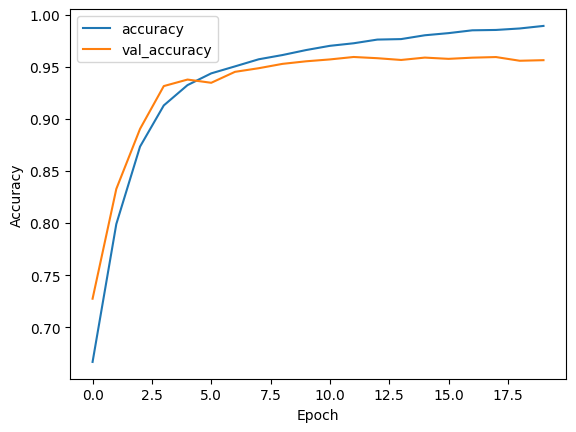

In [43]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(("accuracy","val_accuracy"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [56]:
%%capture
!pip install tf2onnx onnxruntime

In [57]:
import keras
import numpy as np
import tf2onnx
import onnx

In [69]:
input_shape=(X_train.shape[1], 1)
input_shape

(40, 1)

In [64]:
input_signature = [tf.TensorSpec([1, 40], tf.float32, name='x')]
lstm_model.output_names = ["output_names"]
onnx_model, _ = tf2onnx.convert.from_keras(lstm_model, input_signature, opset=13)
onnx.save(onnx_model, "lstm_model_r.onnx")

In [67]:
lstm_model.save('lstm_model_r.h5')
lstm_model.save('lstm_model_r.keras')

In [44]:
m =pd.DataFrame(lstm_model.predict(X_valid)).T.idxmax()
from sklearn.metrics import classification_report
print(classification_report(y_valid, m))

505/505 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
              precision    recall  f1-score   support

           0       0.93      0.86      0.89      2710
           1       0.96      0.96      0.96      2569
           2       0.97      0.98      0.98      2749
           3       0.97      0.98      0.98      2713
           4       0.93      0.96      0.95      2711
           5       0.98      0.99      0.99      2685

    accuracy                           0.96     16137
   macro avg       0.96      0.96      0.96     16137
weighted avg       0.96      0.96      0.96     16137



In [45]:
accuracy_score(y_valid, m)

0.9575509698209085

In [46]:
m =pd.DataFrame(lstm_model.predict(df_test[list_corr_rhythm_2[:-1]])).T.idxmax()
from sklearn.metrics import classification_report
print(classification_report(df_test['rhythm'], m))


1317/1317 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step
              precision    recall  f1-score   support

           0       0.98      0.93      0.95     26890
           1       0.92      0.93      0.93      4418
           2       0.85      0.96      0.90      3577
           3       0.79      0.94      0.86      1136
           4       0.87      0.93      0.90      5419
           5       0.79      0.90      0.84       692

    accuracy                           0.93     42132
   macro avg       0.87      0.93      0.90     42132
weighted avg       0.94      0.93      0.93     42132

